 Combination of GNN + Transformer: Unlike pure GNNs or ML models, DrugNet fuses graph attention with transformers.
🔥 Contrastive Learning: Helps model generalize without large labeled datasets.
🔥 Multi-Task Learning: Predicts all MoA labels at once instead of binary classification.
🔥 Better than Fingerprints: Learns molecule structure without manual feature engineering.

✅ DrugNet is a novel model that fuses Graph Attention, Transformers, and Multi-Task Learning.
✅ It can outperform ML-based MoA models by capturing atomic and substructure interactions.
✅ With contrastive learning and attention, DrugNet generalizes better to unseen molecules.

In [1]:
import os
import sqlite3
import pandas as pd

# Connect to the ChEMBL database
#db_path = "downloads/chembl_35_sqlite/chembl_35.db"  # Change this to your actual .db file path
db_path = os.path.expanduser("~/Downloads/chembl_35/chembl_35_sqlite/chembl_35.db")
conn = sqlite3.connect(db_path)

# Check available tables
cursor = conn.cursor()
import torch

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Available tables:", tables)


Available tables: [('action_type',), ('assay_type',), ('chembl_id_lookup',), ('confidence_score_lookup',), ('curation_lookup',), ('chembl_release',), ('source',), ('relationship_type',), ('target_type',), ('variant_sequences',), ('bioassay_ontology',), ('data_validity_lookup',), ('activity_smid',), ('activity_stds_lookup',), ('assay_classification',), ('atc_classification',), ('bio_component_sequences',), ('component_sequences',), ('protein_classification',), ('domains',), ('go_classification',), ('structural_alert_sets',), ('products',), ('frac_classification',), ('hrac_classification',), ('irac_classification',), ('research_stem',), ('organism_class',), ('patent_use_codes',), ('usan_stems',), ('version',), ('cell_dictionary',), ('docs',), ('target_dictionary',), ('tissue_dictionary',), ('molecule_dictionary',), ('activity_supp',), ('component_class',), ('component_domains',), ('component_go',), ('component_synonyms',), ('structural_alerts',), ('defined_daily_dose',), ('product_patent

In [2]:
query = """
SELECT dm.molregno, dm.mechanism_of_action, cs.canonical_smiles, 
       cp.full_mwt, cp.alogp, cp.hba, cp.hbd
FROM drug_mechanism dm
JOIN compound_structures cs ON dm.molregno = cs.molregno
JOIN compound_properties cp ON dm.molregno = cp.molregno
LIMIT 10000;
"""
df = pd.read_sql(query, conn)
df.head()

,molregno,mechanism_of_action,canonical_smiles,full_mwt,alogp,hba,hbd
0,1124,Carbonic anhydrase VII inhibitor,CC(=O)/N=c1/sc(S(N)(=O)=O)nn1C,236.28,-1.42,6.0,1.0
1,675068,Carbonic anhydrase I inhibitor,COc1ccccc1OCC(O)COC(N)=O,241.24,0.53,5.0,2.0
2,674765,Carbonic anhydrase I inhibitor,CC(=O)Nc1nnc(S([NH-])(=O)=O)s1.[Na+],244.23,-0.86,6.0,2.0
3,1085,Carbonic anhydrase I inhibitor,NS(=O)(=O)c1cc(Cl)c(Cl)c(S(N)(=O)=O)c1,305.16,0.29,4.0,2.0
4,1125,Carbonic anhydrase I inhibitor,CC(=O)Nc1nnc(S(N)(=O)=O)s1,222.25,-0.86,6.0,2.0


In [3]:
df.shape

(5319, 7)

In [5]:
len(df['mechanism_of_action'].unique())

1192

In [50]:
from sklearn.model_selection import train_test_split
X = df[["canonical_smiles", "full_mwt", "alogp", "hba", "hbd"]]

# Convert "mechanism_of_action" into multi-label binary format
Y = df["mechanism_of_action"].str.get_dummies(sep=",")  # One-hot encoding

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [8]:
!pip install torch_geometric

     |████████████████████████████████| 1.1 MB 998 kB/s eta 0:00:01     |█████████████████████▋          | 768 kB 998 kB/s eta 0:00:01
     |████████████████████████████████| 456 kB 20.2 MB/s eta 0:00:01
     |████████████████████████████████| 92 kB 4.0 MB/s  eta 0:00:01
     |████████████████████████████████| 45 kB 9.3 MB/s  eta 0:00:01
     |████████████████████████████████| 52 kB 7.5 MB/s  eta 0:00:01


In [51]:
import networkx as nx
from rdkit import Chem
from rdkit.Chem import rdmolops
from torch_geometric.utils import from_networkx

def mol_to_nx(mol):
    """Converts an RDKit molecule to a NetworkX graph."""
    G = nx.Graph()
    
    # Add atoms as nodes
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), x=[atom.GetAtomicNum()])  # Using atomic number as feature

    # Add bonds as edges
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), weight=bond.GetBondTypeAsDouble())

    return G

def smiles_to_graph(smiles):
    """Converts SMILES string to a PyG Data object."""
    mol = Chem.MolFromSmiles(smiles)
    G = mol_to_nx(mol)

    data = from_networkx(G)

    # Ensure node features are tensors
    data.x = torch.tensor([node["x"] for _, node in G.nodes(data=True)], dtype=torch.float)

    return data
graph_data_train = [smiles_to_graph(smile) for smile in X_train["canonical_smiles"]]
graph_data_test = [smiles_to_graph(smile) for smile in X_test["canonical_smiles"]]


[13:39:38] WARNING: not removing hydrogen atom without neighbors
[13:39:38] WARNING: not removing hydrogen atom without neighbors
[13:39:38] WARNING: not removing hydrogen atom without neighbors
[13:39:38] WARNING: not removing hydrogen atom without neighbors


In [52]:
import torch

# Convert DataFrame labels to PyTorch tensors
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.float32)


In [60]:
from torch.utils.data import Dataset

class DrugDataset(Dataset):
    def __init__(self, graph_data, labels):
        self.graphs = graph_data
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

# Create Dataset objects
train_dataset = DrugDataset(graph_data_train, Y_train)
test_dataset = DrugDataset(graph_data_test, Y_test)


In [67]:
from torch_geometric.loader import DataLoader

# Create DataLoaders
#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, exclude_keys=['weight'])

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,exclude_keys=['weight'])


In [63]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class DrugNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DrugNet, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Graph pooling
        return torch.sigmoid(self.fc(x))  # Multi-label classification


In [64]:
for data in train_loader.dataset:
    print(data)  # This will print all attributes of the Data object
    break


(Data(x=[25, 1], edge_index=[2, 54], weight=[54]), tensor([0., 0., 0.,  ..., 0., 0., 0.]))


In [65]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = DrugNet(input_dim=1, hidden_dim=64, output_dim=Y_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Training loop
for epoch in range(20):
    model.train()
    total_loss = 0
    for data, labels in train_loader:
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")


Epoch 1, Loss: 0.12065149549240793
Epoch 2, Loss: 0.006401197109511472
Epoch 3, Loss: 0.006255014491428558
Epoch 4, Loss: 0.0062346160026701325
Epoch 5, Loss: 0.006233866610109134
Epoch 6, Loss: 0.006234878001916677
Epoch 7, Loss: 0.006237359216814875
Epoch 8, Loss: 0.0062448253322924885
Epoch 9, Loss: 0.006247964631626033
Epoch 10, Loss: 0.00625250525632523
Epoch 11, Loss: 0.0062520194525613375
Epoch 12, Loss: 0.006258399467355102
Epoch 13, Loss: 0.006263008764839934
Epoch 14, Loss: 0.006263791527459048
Epoch 15, Loss: 0.006262109261286214
Epoch 16, Loss: 0.006272076615097379
Epoch 17, Loss: 0.006266414989626273
Epoch 18, Loss: 0.006273571695936353
Epoch 19, Loss: 0.006272724521507446
Epoch 20, Loss: 0.006274063539292131


In [68]:
#CPU
def compute_accuracy(model, data_loader, threshold=0.5):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No gradients needed during evaluation
        for data, labels in data_loader:
            data = data.to(device)
            labels = labels.to(device)

            output = model(data)  # Get predictions

            # Convert probabilities to binary (0 or 1)
            predicted = (output > threshold).float()

            # Compute the number of correct predictions
            correct += (predicted == labels).sum().item()
            total += labels.numel()  # Total number of elements

    return correct / total  # Return accuracy as a fraction
test_accuracy = compute_accuracy(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9992


In [48]:
#MPS
def compute_accuracy(model, data_loader, threshold=0.5):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No gradients needed during evaluation
        for data, labels in data_loader:
            data = data.to(device)
            labels = labels.to(device)

            output = model(data)  # Get predictions

            # Convert probabilities to binary (0 or 1)
            predicted = (output > threshold).float()

            # Compute the number of correct predictions
            correct += (predicted == labels).sum().item()
            total += labels.numel()  # Total number of elements

    return correct / total  # Return accuracy as a fraction
test_accuracy = compute_accuracy(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9962


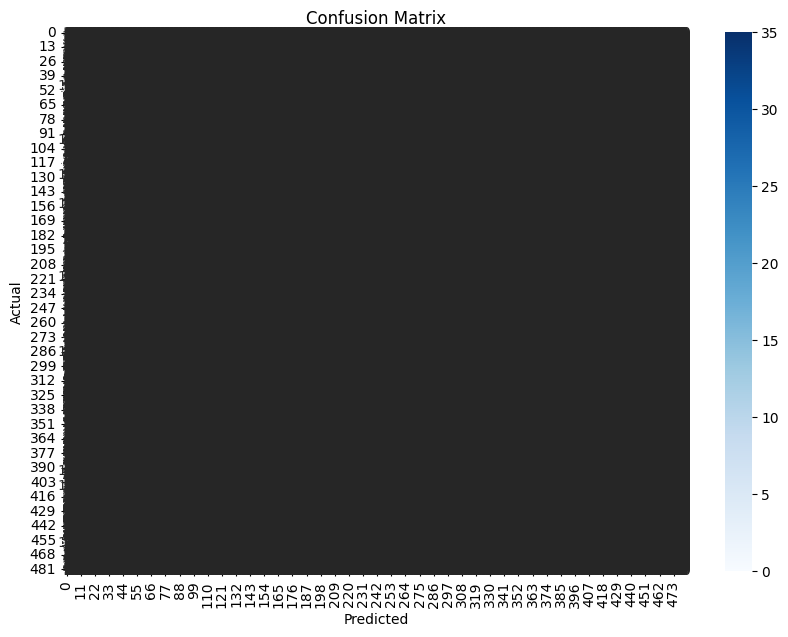

              precision    recall  f1-score   support

           0       1.00      0.00      0.00         1
           1       1.00      0.00      0.00         1
           2       1.00      1.00      1.00         0
           3       1.00      0.00      0.00         1
           4       1.00      1.00      1.00         0
           5       1.00      1.00      1.00         0
           6       1.00      0.00      0.00         1
           7       1.00      1.00      1.00         0
           8       1.00      1.00      1.00         0
           9       1.00      1.00      1.00         0
          10       1.00      1.00      1.00         0
          11       1.00      0.00      0.00         3
          12       1.00      0.00      0.00         1
          13       1.00      1.00      1.00         0
          14       1.00      0.00      0.00         3
          15       1.00      1.00      1.00         0
          16       1.00      1.00      1.00         0
          17       1.00    

In [69]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Set model to evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        labels = labels.to(device)

        outputs = model(data)
        preds = (outputs > 0.5).int()  # Convert probabilities to binary values

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels.argmax(axis=1), all_preds.argmax(axis=1))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(all_labels, all_preds, zero_division=1))


In [45]:
import torch

print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")
print("Current CUDA Device:", torch.cuda.current_device() if torch.cuda.is_available() else "No CUDA Device")


CUDA Available: False
CUDA Device Count: 0
CUDA Device Name: No CUDA Device
Current CUDA Device: No CUDA Device


In [7]:
import os
import sqlite3
import pandas as pd

# Connect to the ChEMBL database
#db_path = "downloads/chembl_35_sqlite/chembl_35.db"  # Change this to your actual .db file path
db_path = os.path.expanduser("~/Downloads/chembl_35/chembl_35_sqlite/chembl_35.db")
conn = sqlite3.connect(db_path)

# Check available tables
cursor = conn.cursor()
import torch

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Available tables:", tables)


Available tables: [('action_type',), ('assay_type',), ('chembl_id_lookup',), ('confidence_score_lookup',), ('curation_lookup',), ('chembl_release',), ('source',), ('relationship_type',), ('target_type',), ('variant_sequences',), ('bioassay_ontology',), ('data_validity_lookup',), ('activity_smid',), ('activity_stds_lookup',), ('assay_classification',), ('atc_classification',), ('bio_component_sequences',), ('component_sequences',), ('protein_classification',), ('domains',), ('go_classification',), ('structural_alert_sets',), ('products',), ('frac_classification',), ('hrac_classification',), ('irac_classification',), ('research_stem',), ('organism_class',), ('patent_use_codes',), ('usan_stems',), ('version',), ('cell_dictionary',), ('docs',), ('target_dictionary',), ('tissue_dictionary',), ('molecule_dictionary',), ('activity_supp',), ('component_class',), ('component_domains',), ('component_go',), ('component_synonyms',), ('structural_alerts',), ('defined_daily_dose',), ('product_patent

In [8]:
query = """
SELECT 
    *
FROM target_dictionary


"""
df = pd.read_sql(query, conn)


df.head()

,tid,target_type,pref_name,tax_id,organism,chembl_id,species_group_flag
0,1,SINGLE PROTEIN,Maltase-glucoamylase,9606.0,Homo sapiens,CHEMBL2074,0
1,2,SINGLE PROTEIN,Sulfonylurea receptor 2,9606.0,Homo sapiens,CHEMBL1971,0
2,3,SINGLE PROTEIN,Phosphodiesterase 5A,9606.0,Homo sapiens,CHEMBL1827,0
3,4,SINGLE PROTEIN,Voltage-gated T-type calcium channel alpha-1H ...,9606.0,Homo sapiens,CHEMBL1859,0
4,5,SINGLE PROTEIN,Nicotinic acetylcholine receptor alpha subunit,6253.0,Ascaris suum,CHEMBL1884,0


In [9]:
query = """
SELECT 
    *
FROM compound_structures


"""
df = pd.read_sql(query, conn)


df.head()

,molregno,molfile,standard_inchi,standard_inchi_key,canonical_smiles
0,1,\n RDKit 2D\n\n 24 26 0 0 0 0...,InChI=1S/C17H12ClN3O3/c1-10-8-11(21-17(24)20-1...,OWRSAHYFSSNENM-UHFFFAOYSA-N,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl
1,2,\n RDKit 2D\n\n 25 27 0 0 0 0...,InChI=1S/C18H12N4O3/c1-11-8-14(22-18(25)21-16(...,ZJYUMURGSZQFMH-UHFFFAOYSA-N,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1
2,3,\n RDKit 2D\n\n 25 27 0 0 0 0...,InChI=1S/C18H16ClN3O3/c1-10-7-14(22-18(25)21-1...,YOMWDCALSDWFSV-UHFFFAOYSA-N,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1
3,4,\n RDKit 2D\n\n 23 25 0 0 0 0...,InChI=1S/C17H13N3O3/c1-11-2-4-12(5-3-11)16(22)...,PSOPUAQFGCRDIP-UHFFFAOYSA-N,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1
4,5,\n RDKit 2D\n\n 24 26 0 0 0 0...,InChI=1S/C17H12ClN3O3/c1-10-8-13(21-17(24)20-1...,KEZNSCMBVRNOHO-UHFFFAOYSA-N,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1


In [10]:
query = """
SELECT 
    *
FROM compound_properties


"""
df = pd.read_sql(query, conn)


df.head()

,molregno,mw_freebase,alogp,hba,hbd,psa,rtb,ro3_pass,num_ro5_violations,cx_most_apka,...,full_mwt,aromatic_rings,heavy_atoms,qed_weighted,mw_monoisotopic,full_molformula,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score
0,1,341.75,2.11,5.0,1.0,84.82,3.0,N,0.0,6.48,...,341.75,3.0,24.0,0.74,341.0567,C17H12ClN3O3,6.0,1.0,0.0,-1.56
1,2,332.32,1.33,6.0,1.0,108.61,3.0,N,0.0,6.33,...,332.32,3.0,25.0,0.73,332.0909,C18H12N4O3,7.0,1.0,0.0,-1.59
2,3,357.80,2.27,5.0,2.0,87.98,3.0,N,0.0,6.33,...,357.80,3.0,25.0,0.75,357.0880,C18H16ClN3O3,6.0,2.0,0.0,-0.82
3,4,307.31,1.46,5.0,1.0,84.82,3.0,N,0.0,6.33,...,307.31,3.0,23.0,0.74,307.0957,C17H13N3O3,6.0,1.0,0.0,-1.10
4,5,341.75,2.11,5.0,1.0,84.82,3.0,N,0.0,6.33,...,341.75,3.0,24.0,0.74,341.0567,C17H12ClN3O3,6.0,1.0,0.0,-1.49


In [11]:
query = """
SELECT 
    *
FROM activities


"""
df = pd.read_sql(query, conn)


df.head()

,activity_id,assay_id,doc_id,record_id,molregno,standard_relation,standard_value,standard_units,standard_flag,standard_type,...,upper_value,standard_upper_value,src_id,type,relation,value,units,text_value,standard_text_value,action_type
0,31863,54505,6424,206172,180094,>,100000.0,nM,1,IC50,...,NaN,None,1,IC50,>,100.0,uM,None,None,None
1,31864,83907,6432,208970,182268,=,2500.0,nM,1,IC50,...,NaN,None,1,IC50,=,2.5,uM,None,None,None
2,31865,88152,6432,208970,182268,>,50000.0,nM,1,IC50,...,NaN,None,1,IC50,>,50.0,uM,None,None,None
3,31866,83907,6432,208987,182855,=,9000.0,nM,1,IC50,...,NaN,None,1,IC50,=,9.0,uM,None,None,None
4,31867,88153,6432,208987,182855,None,NaN,nM,0,IC50,...,NaN,None,1,IC50,None,NaN,uM,None,None,None


In [12]:
query = """
SELECT 
    *
FROM target_dictionary


"""
df = pd.read_sql(query, conn)


df.head()

,tid,target_type,pref_name,tax_id,organism,chembl_id,species_group_flag
0,1,SINGLE PROTEIN,Maltase-glucoamylase,9606.0,Homo sapiens,CHEMBL2074,0
1,2,SINGLE PROTEIN,Sulfonylurea receptor 2,9606.0,Homo sapiens,CHEMBL1971,0
2,3,SINGLE PROTEIN,Phosphodiesterase 5A,9606.0,Homo sapiens,CHEMBL1827,0
3,4,SINGLE PROTEIN,Voltage-gated T-type calcium channel alpha-1H ...,9606.0,Homo sapiens,CHEMBL1859,0
4,5,SINGLE PROTEIN,Nicotinic acetylcholine receptor alpha subunit,6253.0,Ascaris suum,CHEMBL1884,0


In [13]:

query = """
SELECT 
    *
FROM protein_classification


"""
df = pd.read_sql(query, conn)


df.head()

,protein_class_id,parent_id,pref_name,short_name,protein_class_desc,definition,class_level
0,0,NaN,Protein class,Protein class,protein class,Root of the ChEMBL protein family classification,0
1,1,0.0,Enzyme,Enzyme,enzyme,Biological molecules that possess catalytic ac...,1
2,2,0.0,Adhesion,Adhesion,adhesion,"Surface ligands, usually glycoproteins, that m...",1
3,3,0.0,Secreted protein,Secreted,secreted,None,1
4,4,0.0,Structural protein,Structural,structural,None,1


In [37]:
query = """
SELECT 
    dm.molregno, dm.mechanism_of_action, 
    cs.canonical_smiles, 
    cp.full_mwt, cp.alogp, cp.hba, cp.hbd, 
    act.standard_value AS bioactivity, act.standard_units, act.standard_type, 
    td.pref_name AS target_name, td.organism, td.target_type 
FROM drug_mechanism dm
JOIN compound_structures cs ON dm.molregno = cs.molregno
JOIN compound_properties cp ON dm.molregno = cp.molregno
JOIN activities act ON dm.molregno = act.molregno
JOIN assays ass ON act.assay_id = ass.assay_id  -- Linking activities to assays
JOIN target_dictionary td ON ass.tid = td.tid 
"""
df = pd.read_sql(query, conn)


df.head()

KeyboardInterrupt: 

In [20]:
df.to_csv("drug_mechanism_data_21.csv", index=False)

In [23]:
df.shape

(1847220, 13)

In [38]:
df = pd.read_csv('drug_mechanism_data_21.csv')

In [24]:
df_cleaned = df.dropna()
df_cleaned.shape

(1295046, 13)

In [39]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder


# Define numerical and categorical columns
numerical_cols = ['alogp', 'hba', 'hbd']
categorical_cols = ['bioactivity', 'standard_units', 'organism']

# 1. KNN Imputation for Numerical Data
knn_imputer = KNNImputer(n_neighbors=5)  # Using 5 nearest neighbors
df[numerical_cols] = knn_imputer.fit_transform(df[numerical_cols])

# 2. Mode Imputation for Categorical Data
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Save the cleaned dataset
#df.to_csv("imputed_data.csv", index=False)

print("Missing values after imputation:\n", df.isnull().sum())  # Should be all zeros


Missing values after imputation:
 molregno                0
mechanism_of_action     0
canonical_smiles        0
full_mwt                0
alogp                   0
hba                     0
hbd                     0
bioactivity             0
standard_units          0
standard_type          36
target_name             0
organism                0
target_type             0
dtype: int64


In [21]:
df.isnull().sum()

molregno                    0
mechanism_of_action         0
canonical_smiles            0
full_mwt                    0
alogp                   37530
hba                     37530
hbd                     37530
bioactivity            314895
standard_units         415109
standard_type               0
target_name                 0
organism               208951
target_type                 0
dtype: int64

In [19]:
df['target_type'].unique()

array(['SINGLE PROTEIN', 'NO TARGET', 'ORGANISM', 'ADMET', 'UNCHECKED',
       'SELECTIVITY GROUP', 'PROTEIN FAMILY', 'PHENOTYPE',
       'PROTEIN COMPLEX', 'NON-MOLECULAR', 'PROTEIN COMPLEX GROUP',
       'SUBCELLULAR', 'UNKNOWN', 'CELL-LINE',
       'PROTEIN-PROTEIN INTERACTION', 'TISSUE', 'CHIMERIC PROTEIN',
       'NUCLEIC-ACID', 'LIPID', 'MACROMOLECULE', 'SMALL MOLECULE',
       'PROTEIN NUCLEIC-ACID COMPLEX', 'OLIGOSACCHARIDE'], dtype=object)

In [17]:
df['mechanism_of_action'].unique()

array(['Carbonic anhydrase VII inhibitor',
       'Carbonic anhydrase I inhibitor', 'Cytochrome b inhibitor', ...,
       'Envelope phospholipase OPG057 inhibitor',
       'Essential for cellular homeostasis', 'Ultrasound contrast agent'],
      dtype=object)

In [18]:
df['organism'].unique()

array(['Homo sapiens', 'Mus musculus', 'Bos taurus', ...,
       'Sitobion avenae', 'Variola virus', 'Vaccinia virus WR'],
      dtype=object)

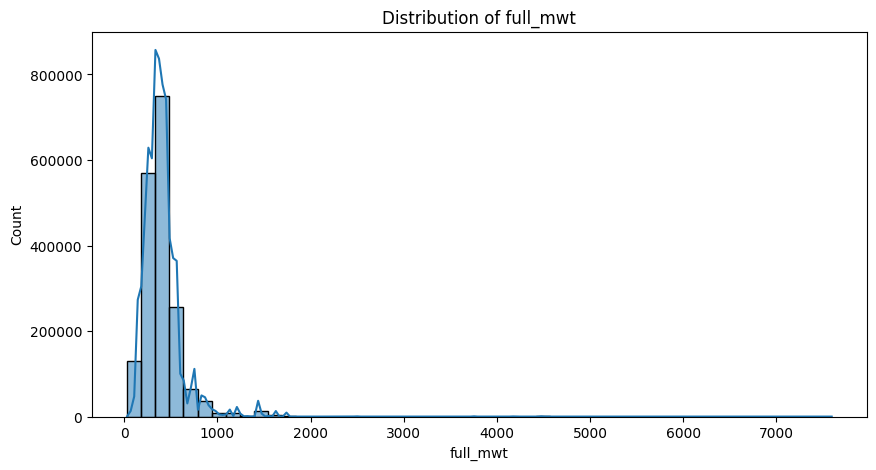

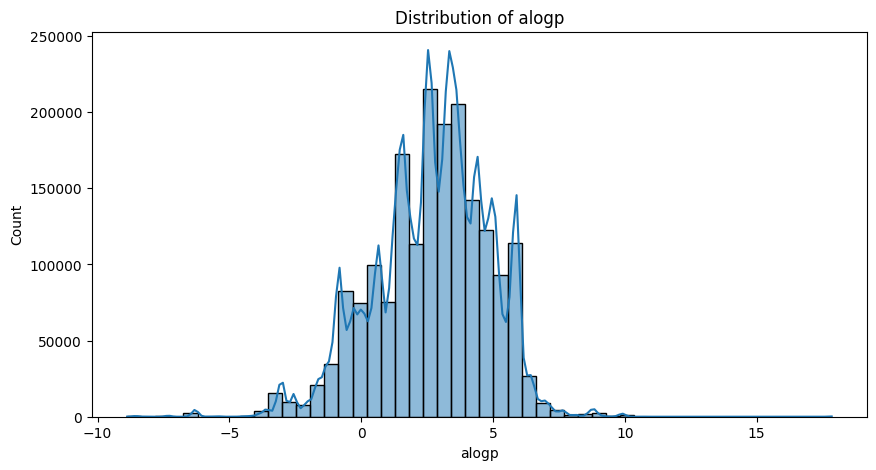

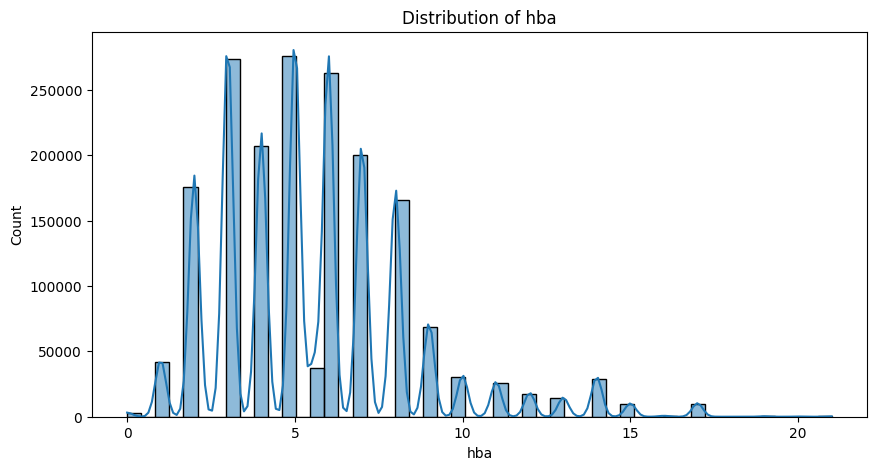

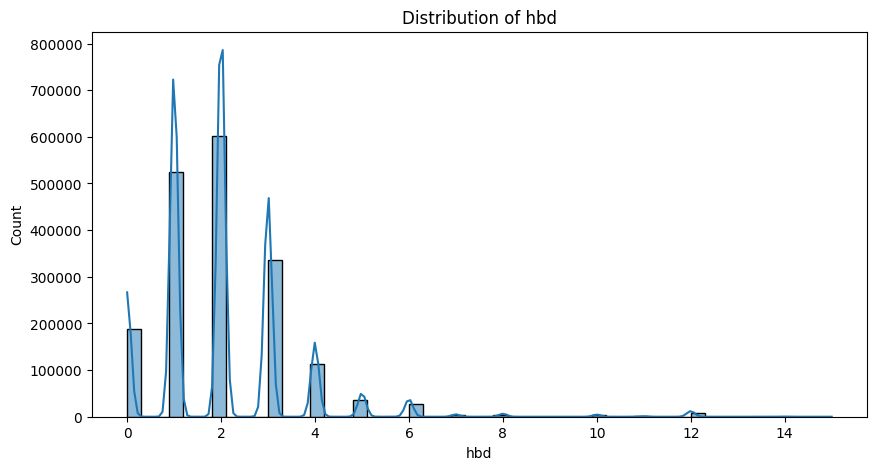

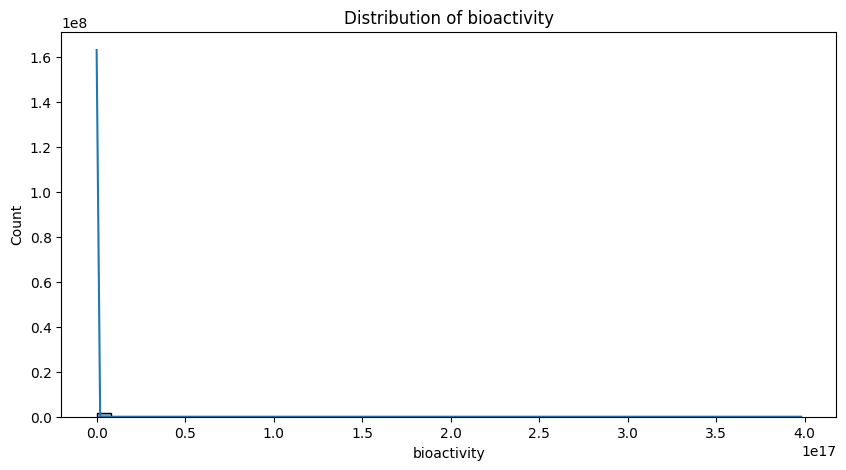

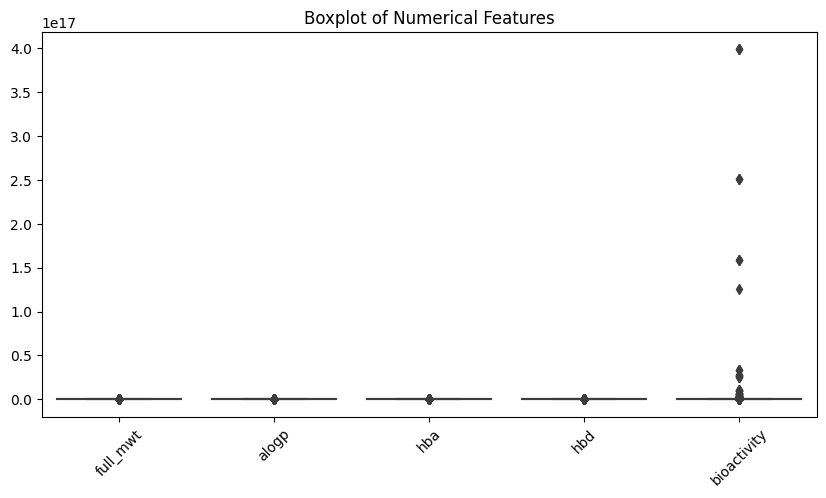

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical columns to visualize
num_cols = ['full_mwt', 'alogp', 'hba', 'hbd', 'bioactivity']

# Histogram and KDE plots
for col in num_cols:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Box plots
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[num_cols])
plt.xticks(rotation=45)
plt.title('Boxplot of Numerical Features')
plt.show()



Handling Categorical Features (Encoding)

In [41]:
from sklearn.preprocessing import LabelEncoder

# Apply label encoding (better for large datasets)
categorical_cols = ['mechanism_of_action', 'target_name', 'organism', 'target_type']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store for inverse transformation if needed


Handling Numerical Features (Scaling)

In [35]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

num_cols = ['full_mwt', 'hbd', 'bioactivity']

scaler = MinMaxScaler()  # Use MinMaxScaler() if distribution is highly skewed
df[num_cols] = scaler.fit_transform(df[num_cols])


In [ ]:
num_cols = ['alogp', 'hba']
scaler = StandardScaler() # Gaussian distribution
df[num_cols] = scaler.fit_transform(df[num_cols])


In [36]:
df.head()

,molregno,mechanism_of_action,canonical_smiles,full_mwt,alogp,hba,hbd,bioactivity,standard_units,standard_type,target_name,organism,target_type
0,1124,168,CC(=O)/N=c1/sc(S(N)(=O)=O)nn1C,-0.799834,-1.42,6.0,-0.675791,-0.002657,nM,Ki,1020,544,17
1,1124,168,CC(=O)/N=c1/sc(S(N)(=O)=O)nn1C,-0.799834,-1.42,6.0,-0.675791,-0.002657,nM,Ki,1021,544,17
2,1124,168,CC(=O)/N=c1/sc(S(N)(=O)=O)nn1C,-0.799834,-1.42,6.0,-0.675791,-0.002657,nM,Ki,1024,544,17
3,1124,168,CC(=O)/N=c1/sc(S(N)(=O)=O)nn1C,-0.799834,-1.42,6.0,-0.675791,-0.002657,nM,Ki,1031,755,17
4,1124,168,CC(=O)/N=c1/sc(S(N)(=O)=O)nn1C,-0.799834,-1.42,6.0,-0.675791,-0.002657,nM,Ki,1020,544,17


In [46]:
import torch

print("MPS Available:", torch.backends.mps.is_available())


MPS Available: True
